In [1]:
import spacy
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, hashing_trick, text_to_word_sequence
from tqdm.auto import tqdm
tqdm.pandas(desc="my bar!")

c:\Users\kevin\anaconda3\envs\ml_project_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_amazon = pd.read_csv("amazon_cells_labelled.txt", sep="\t")
df_imdb = pd.read_csv("imdb_labelled.txt", sep="\t")
df_yelp = pd.read_csv("yelp_labelled.txt", sep="\t")


In [3]:
df_reviews = pd.concat([df_amazon, df_imdb, df_yelp])
df_reviews = df_reviews.sample(frac=1).reset_index(drop=True)
df_reviews

,reviews,sentiment
0,We waited for forty five minutes in vain.,0
1,Battery life still not long enough in Motorola...,0
2,I would definitely recommend the wings as well...,1
3,This product is ideal for people like me whose...,1
4,You never know if you pushed it hard enough or...,0
...,...,...
2743,Just don't know why they were so slow.,0
2744,"The ripped banana was not only ripped, but pet...",0
2745,Best headset ever!!!.,1
2746,This place is disgusting!,0


In [4]:
df_reviews.isnull().sum()

reviews      0
sentiment    0
dtype: int64

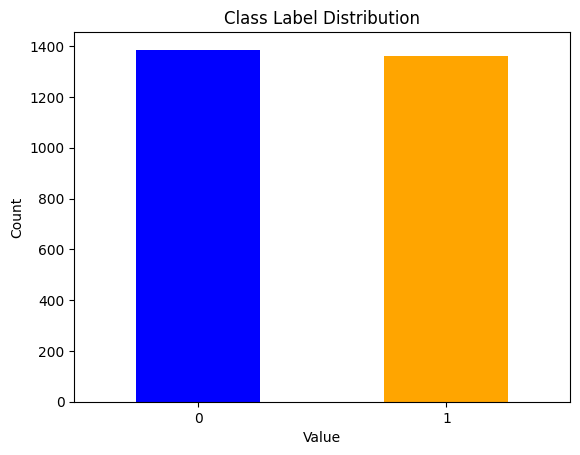

In [5]:
# Count the occurrences of 0 and 1 in the 'column_name'
counts = df_reviews['sentiment'].value_counts()

# Plot the bar chart
counts.plot(kind='bar', color=['blue', 'orange'])

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Class Label Distribution')

# Display the plot
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
plt.show()

In [7]:
nlp = spacy.load("en_core_web_sm")
def preprocessor(text):
    text = text.lower()
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ''.join(emoticons).replace('-', '')
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc if token.text not in STOP_WORDS])
    return text

In [8]:
df_reviews["preprocessed"] = df_reviews["reviews"].progress_apply(preprocessor)

my bar!: 100%|██████████| 2748/2748 [00:10<00:00, 272.95it/s]


In [9]:
df_reviews[df_reviews["sentiment"] == 1]

,reviews,sentiment,preprocessed
2,I would definitely recommend the wings as well...,1,definitely recommend wing pizza
3,This product is ideal for people like me whose...,1,product ideal people like ear sensitive
5,Car charger as well as AC charger are included...,1,car charger ac charger include sure run juice ...
6,"Just consider the excellent story, solid actin...",1,consider excellent story solid act look film a...
11,Also its slim enough to fit into my alarm cloc...,1,slim fit alarm clock docking station remove case
...,...,...,...
2735,I didn't know pulled pork could be soooo delic...,1,didn t know pull pork soooo delicious
2737,"It is light, has plenty of battery capacity, a...",1,light plenty battery capacity confortable wear...
2741,"Great it was new packaged nice works good, no ...",1,great new package nice work good problem come ...
2742,"The acting is fantastic, the stories are seaml...",1,acting fantastic story seamlessly weave dog sp...


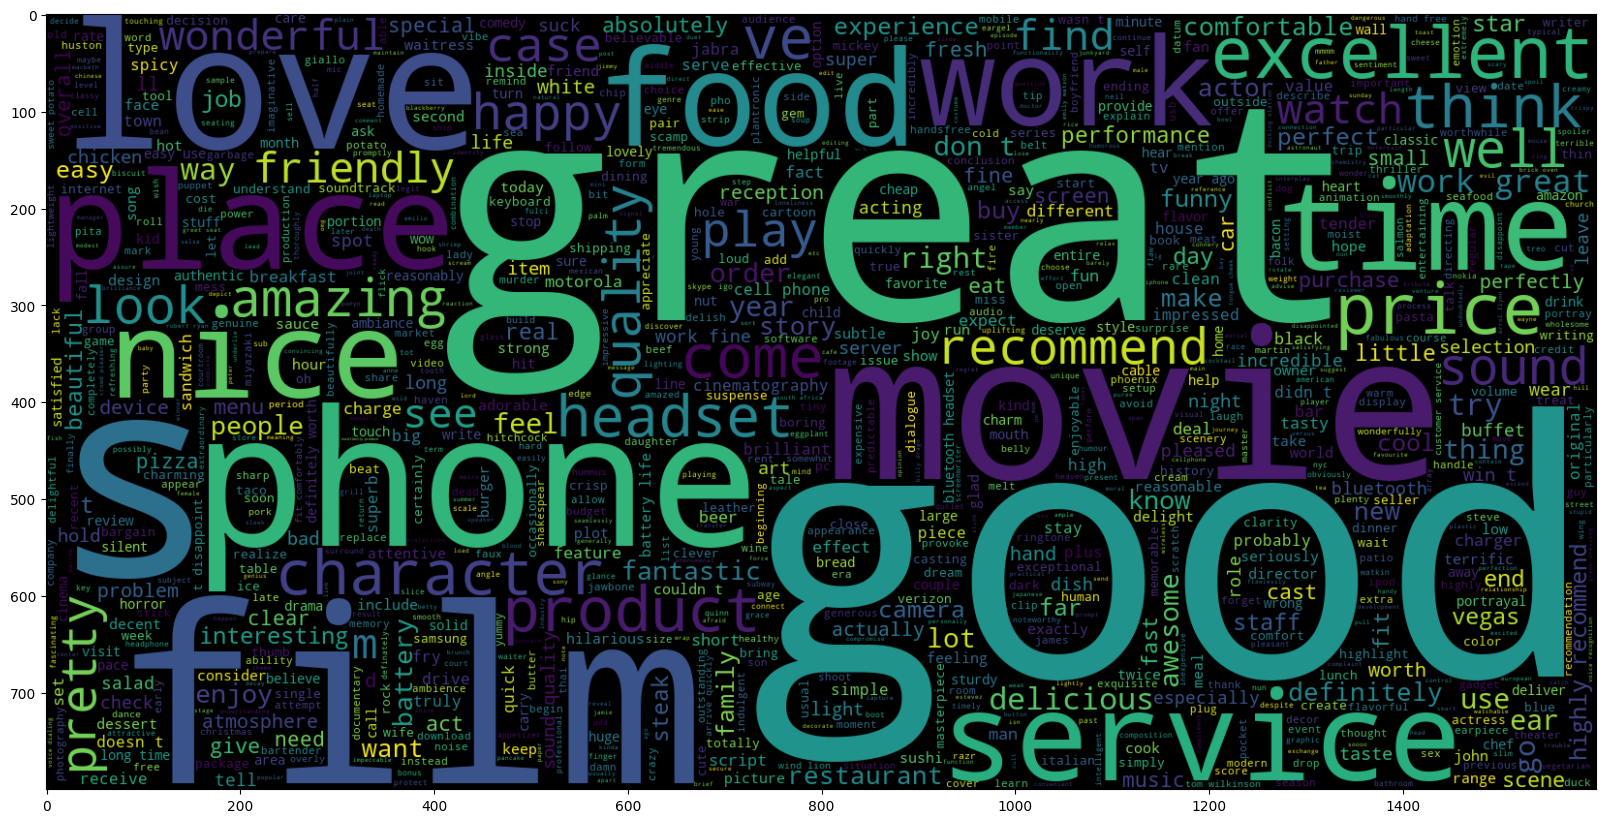

In [10]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_reviews[df_reviews.sentiment == 1].preprocessed))
plt.imshow(wc, interpolation = 'bilinear')

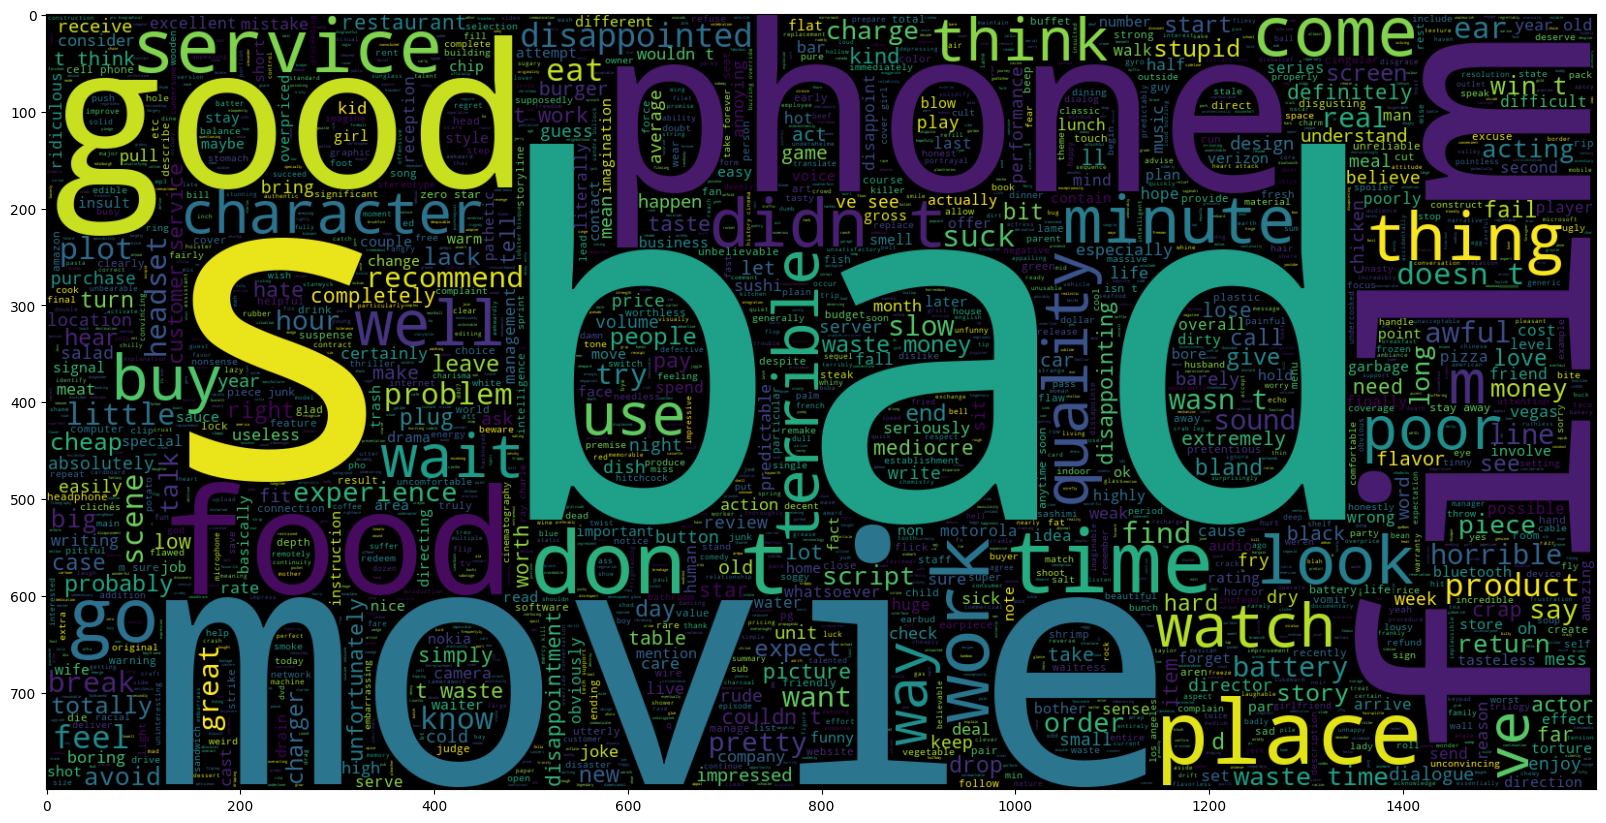

In [11]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_reviews[df_reviews.sentiment == 0].preprocessed))
plt.imshow(wc, interpolation = 'bilinear')

In [13]:
x = df_reviews["preprocessed"]
y = df_reviews["sentiment"].values

In [14]:
x_vect = [text.split() for text in x.tolist()]
DIM = 100
wv2_model = Word2Vec(sentences=x_vect, vector_size=DIM, window=10, min_count=1)

In [15]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_vect)
word_index = tokenizer.word_index
vocab_size=len(word_index) + 1
print("Vocab Size")
print(vocab_size)

# Padding data

sequences = tokenizer.texts_to_sequences(x_vect)
x = pad_sequences(sequences, maxlen=1000)

Vocab Size
4142


In [16]:
# Import tensor representations for words
vocab = tokenizer.word_index
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))
  for word, i in vocab.items():
    try:
      weight_matrix[i] = model.wv[word]
    except KeyError:
      pass
  return weight_matrix

In [17]:
embeddings_matrix = get_weight_matrix(wv2_model)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, output_dim=DIM, input_length=1000, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         414200    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 531,577
Trainable params: 117,377
Non-trainable params: 414,200
_________________________________________________________________


In [21]:
history = model.fit(x, y, epochs=10, validation_split=0.3)

Epoch 1/10
61/61 [==============================] - 11s 93ms/step - loss: 0.6940 - accuracy: 0.4945 - val_loss: 0.6915 - val_accuracy: 0.5236
Epoch 2/10
61/61 [==============================] - 5s 78ms/step - loss: 0.6919 - accuracy: 0.5434 - val_loss: 0.6905 - val_accuracy: 0.5297
Epoch 3/10
61/61 [==============================] - 5s 80ms/step - loss: 0.6914 - accuracy: 0.5398 - val_loss: 0.6896 - val_accuracy: 0.5358
Epoch 4/10
61/61 [==============================] - 5s 81ms/step - loss: 0.6900 - accuracy: 0.5476 - val_loss: 0.6886 - val_accuracy: 0.5491
Epoch 5/10
61/61 [==============================] - 5s 82ms/step - loss: 0.6887 - accuracy: 0.5356 - val_loss: 0.6861 - val_accuracy: 0.5721
Epoch 6/10
61/61 [==============================] - 5s 80ms/step - loss: 0.6872 - accuracy: 0.5476 - val_loss: 0.6841 - val_accuracy: 0.5673
Epoch 7/10
61/61 [==============================] - 5s 81ms/step - loss: 0.6867 - accuracy: 0.5632 - val_loss: 0.6834 - val_accuracy: 0.5697
Epoch 8/10
6

In [12]:
# List all physical devices (CPU and GPU)
gpus = tf.config.list_physical_devices('GPU')

if len(gpus) > 0:
    print("TensorFlow is using the following GPU(s):")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs found. TensorFlow is using CPU.")

TensorFlow is using the following GPU(s):
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


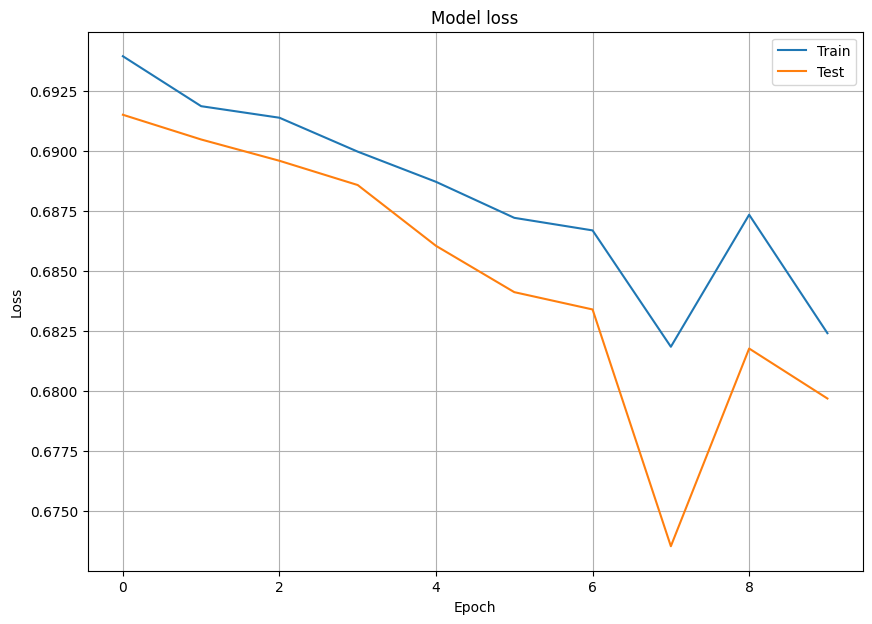

In [ ]:
# Visualize the results:
plt.figure(figsize=(10, 7))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

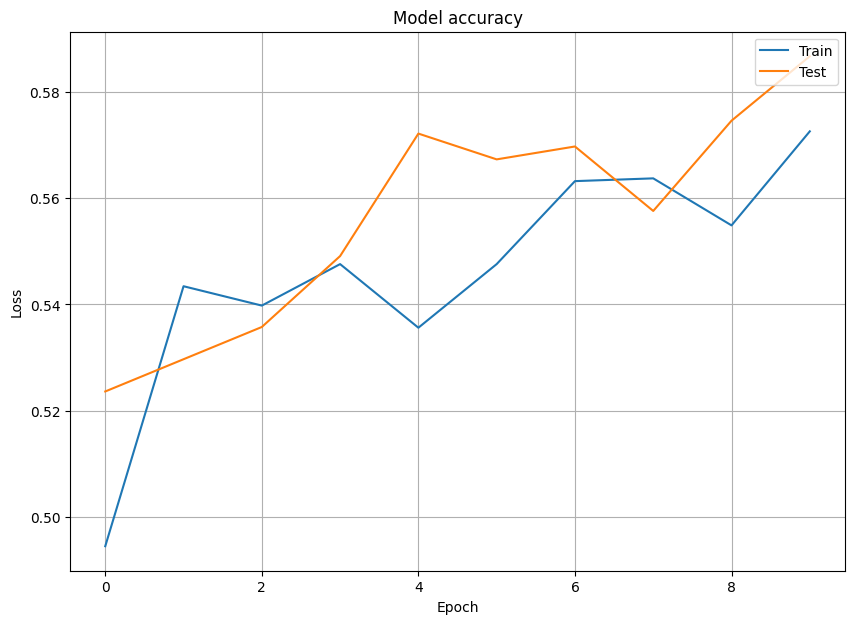

In [24]:
# Visualize the results:
plt.figure(figsize=(10, 7))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
# Save model
model.save("models/model1.keras")